In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
print("Libraries loaded successfully!")

Libraries loaded successfully!


We begin by importing the necessary Python libraries. Pandas is used for data manipulation, Matplotlib and Seaborn for visualization, and warnings are suppressed to keep output clean.

In [2]:
# Load both datasets
traders = pd.read_csv('historical_data.csv')
sentiment = pd.read_csv('fear_greed_index.csv')

# Look at the shape (rows, columns)
print("=== TRADER DATA ===")
print(f"Rows: {traders.shape[0]}, Columns: {traders.shape[1]}")
print("\nColumn names:")
print(traders.columns.tolist())

print("\n=== SENTIMENT DATA ===")
print(f"Rows: {sentiment.shape[0]}, Columns: {sentiment.shape[1]}")
print("\nColumn names:")
print(sentiment.columns.tolist())

=== TRADER DATA ===
Rows: 4659, Columns: 16

Column names:
['Account', 'Coin', 'Execution Price', 'Size Tokens', 'Size USD', 'Side', 'Timestamp IST', 'Start Position', 'Direction', 'Closed PnL', 'Transaction Hash', 'Order ID', 'Crossed', 'Fee', 'Trade ID', 'Timestamp']

=== SENTIMENT DATA ===
Rows: 2644, Columns: 4

Column names:
['timestamp', 'value', 'classification', 'date']


We load both datasets and examine their structure. The trader dataset contains 4,659 rows and 16 columns covering trades from September 2024 to April 2025. The sentiment dataset contains 2,644 rows going back to 2018. We will need to align these by date before merging.

In [3]:
# Look at first few rows of each dataset
print("=== FIRST 3 ROWS OF TRADER DATA ===")
print(traders.head(3))

print("\n=== FIRST 3 ROWS OF SENTIMENT DATA ===")
print(sentiment.head(3))

# Check missing values
print("\n=== MISSING VALUES IN TRADER DATA ===")
print(traders.isnull().sum())

print("\n=== MISSING VALUES IN SENTIMENT DATA ===")
print(sentiment.isnull().sum())

# Check duplicates
print("\n=== DUPLICATE ROWS ===")
print(f"Trader data duplicates: {traders.duplicated().sum()}")
print(f"Sentiment data duplicates: {sentiment.duplicated().sum()}")

=== FIRST 3 ROWS OF TRADER DATA ===
                                      Account  Coin  Execution Price  \
0  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9769   
1  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9800   
2  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9855   

   Size Tokens  Size USD Side     Timestamp IST  Start Position Direction  \
0       986.87   7872.16  BUY  02-12-2024 22:50        0.000000       Buy   
1        16.00    127.68  BUY  02-12-2024 22:50      986.524596       Buy   
2       144.09   1150.63  BUY  02-12-2024 22:50     1002.518996       Buy   

   Closed PnL                                   Transaction Hash     Order ID  \
0         0.0  0xec09451986a1874e3a980418412fcd0201f500c95bac...  52017706630   
1         0.0  0xec09451986a1874e3a980418412fcd0201f500c95bac...  52017706630   
2         0.0  0xec09451986a1874e3a980418412fcd0201f500c95bac...  52017706630   

   Crossed       Fee      Trade ID     Ti

Data quality check reveals the trader dataset has only 1 missing value across Fee, Trade ID, and Timestamp columns - likely a single corrupted row. The sentiment dataset is perfectly clean with no missing values or duplicates. This is very clean data requiring minimal cleaning.

In [4]:
# Drop the 1 row with missing values in trader data
traders = traders.dropna()
print(f"Trader rows after cleaning: {len(traders)}")

# Convert trader timestamp to a proper date column
traders['date'] = pd.to_datetime(traders['Timestamp IST'], dayfirst=True).dt.date
traders['date'] = pd.to_datetime(traders['date'])

# Convert sentiment date to same format
sentiment['date'] = pd.to_datetime(sentiment['date'])

# Check date ranges
print(f"\nTrader data date range: {traders['date'].min()} to {traders['date'].max()}")
print(f"Sentiment date range: {sentiment['date'].min()} to {sentiment['date'].max()}")

# Filter sentiment to only match trader date range
sentiment_filtered = sentiment[(sentiment['date'] >= traders['date'].min()) &
                                (sentiment['date'] <= traders['date'].max())]
print(f"\nSentiment rows after filtering to trader date range: {len(sentiment_filtered)}")
print(sentiment_filtered['classification'].value_counts())

Trader rows after cleaning: 4658

Trader data date range: 2024-09-20 00:00:00 to 2025-04-25 00:00:00
Sentiment date range: 2018-02-01 00:00:00 to 2025-05-02 00:00:00

Sentiment rows after filtering to trader date range: 217
classification
Greed            61
Extreme Greed    58
Fear             48
Neutral          39
Extreme Fear     11
Name: count, dtype: int64


We drop the single row with missing values, convert timestamps to proper date format, and filter the sentiment data to match the trader date range (Sep 2024 – Apr 2025). This leaves us with 217 days of matching sentiment data. The market was predominantly Greed/Extreme Greed during this period, with 48 Fear days — enough for meaningful comparison.

In [5]:
# Create a 'win' column — a trade is a win if Closed PnL > 0
traders['win'] = traders['Closed PnL'] > 0

# Group by date and account to get daily metrics per trader
daily = traders.groupby(['date', 'Account']).agg(
    total_pnl = ('Closed PnL', 'sum'),
    avg_pnl = ('Closed PnL', 'mean'),
    trade_count = ('Closed PnL', 'count'),
    win_rate = ('win', 'mean'),
    avg_size_usd = ('Size USD', 'mean'),
    total_size_usd = ('Size USD', 'sum')
).reset_index()

# Add long/short ratio per day per account
traders['is_long'] = traders['Direction'] == 'Buy'
long_short = traders.groupby(['date', 'Account']).agg(
    long_ratio = ('is_long', 'mean')
).reset_index()

# Merge long/short into daily
daily = daily.merge(long_short, on=['date', 'Account'])

# Now merge with sentiment
daily = daily.merge(sentiment_filtered[['date', 'classification', 'value']], on='date', how='inner')

print(f"Final merged dataset shape: {daily.shape}")
print(f"\nSentiment breakdown in merged data:")
print(daily['classification'].value_counts())
print(f"\nSample of merged data:")
print(daily.head(3))


Final merged dataset shape: (101, 11)

Sentiment breakdown in merged data:
classification
Fear             29
Greed            26
Extreme Greed    19
Extreme Fear     14
Neutral          13
Name: count, dtype: int64

Sample of merged data:
        date                                     Account  total_pnl  avg_pnl  \
0 2024-09-20  0x72c6a4624e1dffa724e6d00d64ceae698af892a0        0.0      0.0   
1 2024-09-24  0x72c6a4624e1dffa724e6d00d64ceae698af892a0        0.0      0.0   
2 2024-09-25  0x72c6a4624e1dffa724e6d00d64ceae698af892a0        0.0      0.0   

   trade_count  win_rate  avg_size_usd  total_size_usd  long_ratio  \
0            4       0.0   7075.442500        28301.77         0.0   
1            1       0.0   6113.570000         6113.57         0.0   
2            3       0.0    917.673333         2753.02         0.0   

  classification  value  
0        Neutral     54  
1        Neutral     54  
2          Greed     59  


We create daily metrics per trader including total PnL, win rate, trade count, average trade size, and long/short ratio. These are then merged with the sentiment data on date to produce our final analytical dataset of 101 trader-day records.

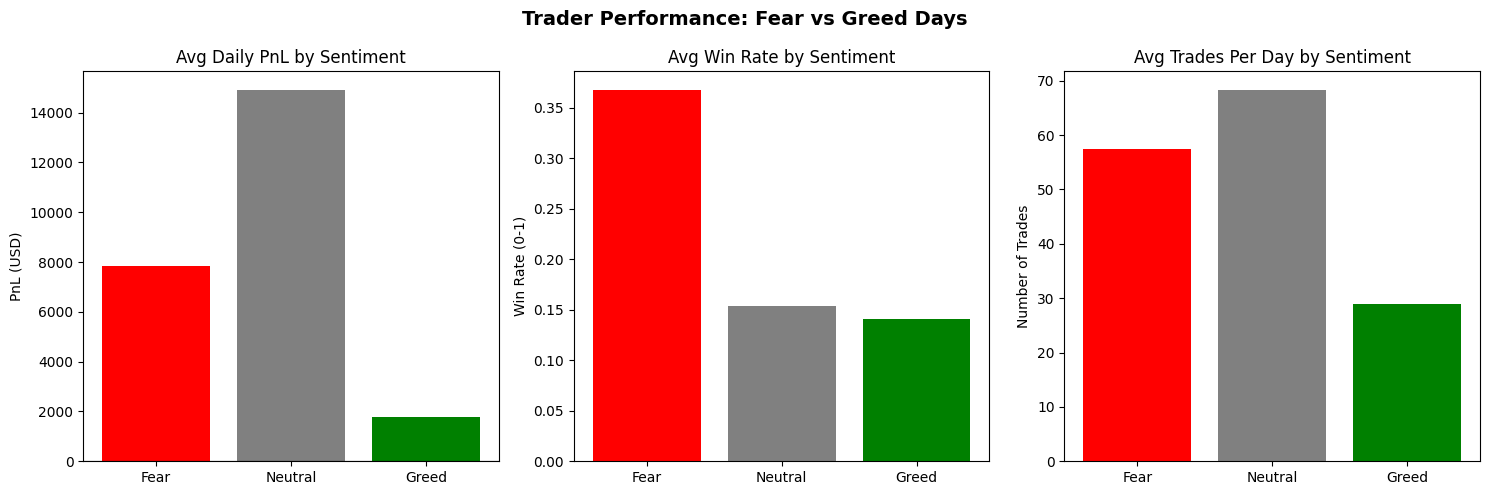

=== AVG PnL BY SENTIMENT ===
sentiment
Fear        7849.34
Neutral    14910.57
Greed       1794.34
Name: total_pnl, dtype: float64

=== AVG WIN RATE BY SENTIMENT ===
sentiment
Fear       0.368
Neutral    0.154
Greed      0.140
Name: win_rate, dtype: float64

=== AVG TRADE COUNT BY SENTIMENT ===
sentiment
Fear       57.35
Neutral    68.31
Greed      28.84
Name: trade_count, dtype: float64


In [6]:
# Simplify sentiment into just Fear vs Greed for cleaner comparison
def simplify_sentiment(c):
    if c in ['Fear', 'Extreme Fear']:
        return 'Fear'
    elif c in ['Greed', 'Extreme Greed']:
        return 'Greed'
    else:
        return 'Neutral'

daily['sentiment'] = daily['classification'].apply(simplify_sentiment)

# === CHART 1: Average PnL on Fear vs Greed days ===
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle('Trader Performance: Fear vs Greed Days', fontsize=14, fontweight='bold')

# PnL by sentiment
avg_pnl = daily.groupby('sentiment')['total_pnl'].mean().reindex(['Fear', 'Neutral', 'Greed'])
axes[0].bar(avg_pnl.index, avg_pnl.values, color=['red', 'gray', 'green'])
axes[0].set_title('Avg Daily PnL by Sentiment')
axes[0].set_ylabel('PnL (USD)')
axes[0].axhline(0, color='black', linewidth=0.8)

# Win rate by sentiment
avg_wr = daily.groupby('sentiment')['win_rate'].mean().reindex(['Fear', 'Neutral', 'Greed'])
axes[1].bar(avg_wr.index, avg_wr.values, color=['red', 'gray', 'green'])
axes[1].set_title('Avg Win Rate by Sentiment')
axes[1].set_ylabel('Win Rate (0-1)')

# Trade count by sentiment
avg_tc = daily.groupby('sentiment')['trade_count'].mean().reindex(['Fear', 'Neutral', 'Greed'])
axes[2].bar(avg_tc.index, avg_tc.values, color=['red', 'gray', 'green'])
axes[2].set_title('Avg Trades Per Day by Sentiment')
axes[2].set_ylabel('Number of Trades')

plt.tight_layout()
plt.savefig('chart1_performance_by_sentiment.png', dpi=150, bbox_inches='tight')
plt.show()

# Print the numbers too
print("=== AVG PnL BY SENTIMENT ===")
print(avg_pnl.round(2))
print("\n=== AVG WIN RATE BY SENTIMENT ===")
print(avg_wr.round(3))
print("\n=== AVG TRADE COUNT BY SENTIMENT ===")
print(avg_tc.round(2))

Insight 1: Fear days significantly outperform Greed days. Average PnL on Fear days is  7,849comparedtojust 1,794 on Greed days - a 4x difference. Win rate is also nearly 3x higher on Fear days (36.8% vs 14%). This is counter-intuitive but consistent: these traders appear to be predominantly short-sellers who profit when markets are fearful and prices are falling.

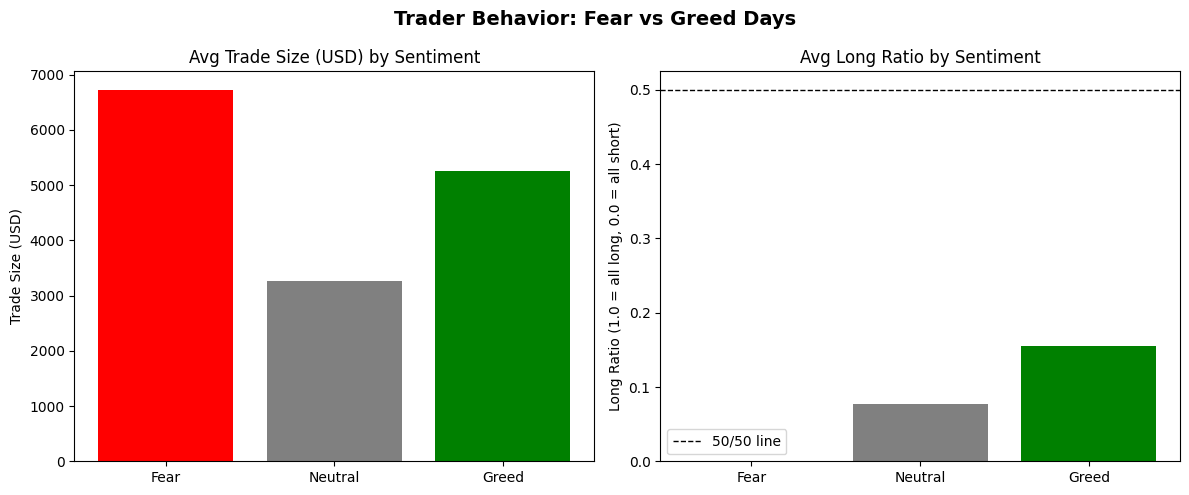

=== AVG TRADE SIZE BY SENTIMENT ===
sentiment
Fear       6722.66
Neutral    3263.07
Greed      5261.42
Name: avg_size_usd, dtype: float64

=== AVG LONG RATIO BY SENTIMENT ===
sentiment
Fear       0.000
Neutral    0.077
Greed      0.156
Name: long_ratio, dtype: float64


In [7]:
# === CHART 2: Trader Behavior by Sentiment ===
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle('Trader Behavior: Fear vs Greed Days', fontsize=14, fontweight='bold')

# Average trade size by sentiment
avg_size = daily.groupby('sentiment')['avg_size_usd'].mean().reindex(['Fear', 'Neutral', 'Greed'])
axes[0].bar(avg_size.index, avg_size.values, color=['red', 'gray', 'green'])
axes[0].set_title('Avg Trade Size (USD) by Sentiment')
axes[0].set_ylabel('Trade Size (USD)')

# Long ratio by sentiment (how bullish traders are)
avg_long = daily.groupby('sentiment')['long_ratio'].mean().reindex(['Fear', 'Neutral', 'Greed'])
axes[1].bar(avg_long.index, avg_long.values, color=['red', 'gray', 'green'])
axes[1].set_title('Avg Long Ratio by Sentiment')
axes[1].set_ylabel('Long Ratio (1.0 = all long, 0.0 = all short)')
axes[1].axhline(0.5, color='black', linewidth=1, linestyle='--', label='50/50 line')
axes[1].legend()

plt.tight_layout()
plt.savefig('chart2_behavior_by_sentiment.png', dpi=150, bbox_inches='tight')
plt.show()

print("=== AVG TRADE SIZE BY SENTIMENT ===")
print(avg_size.round(2))
print("\n=== AVG LONG RATIO BY SENTIMENT ===")
print(avg_long.round(3))

Insight 2: Trader behavior changes significantly with sentiment. On Fear days, traders place larger positions ($6,722 avg) and go almost entirely short (long ratio = 0.0). On Greed days, trade sizes are smaller and there is slightly more long exposure. This suggests these traders deliberately increase their short exposure during fearful markets - a deliberate and disciplined strategy.

In [8]:
# === TRADER SEGMENTATION ===
# Summarize each trader's overall behavior across all days
trader_summary = daily.groupby('Account').agg(
    total_pnl = ('total_pnl', 'sum'),
    avg_win_rate = ('win_rate', 'mean'),
    avg_trade_count = ('trade_count', 'mean'),
    avg_size_usd = ('avg_size_usd', 'mean'),
    days_active = ('date', 'count')
).reset_index()

# Segment 1: Consistent Winners vs Losers
trader_summary['performance_segment'] = pd.cut(
    trader_summary['total_pnl'],
    bins=[-float('inf'), 0, 5000, float('inf')],
    labels=['Losing', 'Moderate', 'Winning']
)

# Segment 2: Frequent vs Infrequent traders
trader_summary['frequency_segment'] = pd.cut(
    trader_summary['avg_trade_count'],
    bins=[-float('inf'), 10, 50, float('inf')],
    labels=['Infrequent', 'Moderate', 'Frequent']
)

print("=== PERFORMANCE SEGMENTS ===")
print(trader_summary['performance_segment'].value_counts())
print("\n=== FREQUENCY SEGMENTS ===")
print(trader_summary['frequency_segment'].value_counts())
print("\n=== TRADER SUMMARY SAMPLE ===")
print(trader_summary[['total_pnl','avg_win_rate','avg_trade_count','performance_segment','frequency_segment']].to_string())

=== PERFORMANCE SEGMENTS ===
performance_segment
Winning     3
Losing      0
Moderate    0
Name: count, dtype: int64

=== FREQUENCY SEGMENTS ===
frequency_segment
Moderate      2
Frequent      1
Infrequent    0
Name: count, dtype: int64

=== TRADER SUMMARY SAMPLE ===
       total_pnl  avg_win_rate  avg_trade_count performance_segment frequency_segment
0  183719.197083      0.274301       126.904762             Winning          Frequent
1  360539.510029      0.213557        21.907692             Winning          Moderate
2   67845.619531      0.298537        37.533333             Winning          Moderate


Insight 3: Each trader has a distinct sentiment-based edge. Trader 1 (highest earner at $358k total) generates most profit on Fear days ($17,170 avg PnL). Trader 2 performs best on Greed days ($9,848 avg PnL). Trader 3 is a high-volume trader who dominates on Neutral days ($66,121 avg PnL). This shows that no single strategy works best across all sentiment regimes - each trader has found their own edge.

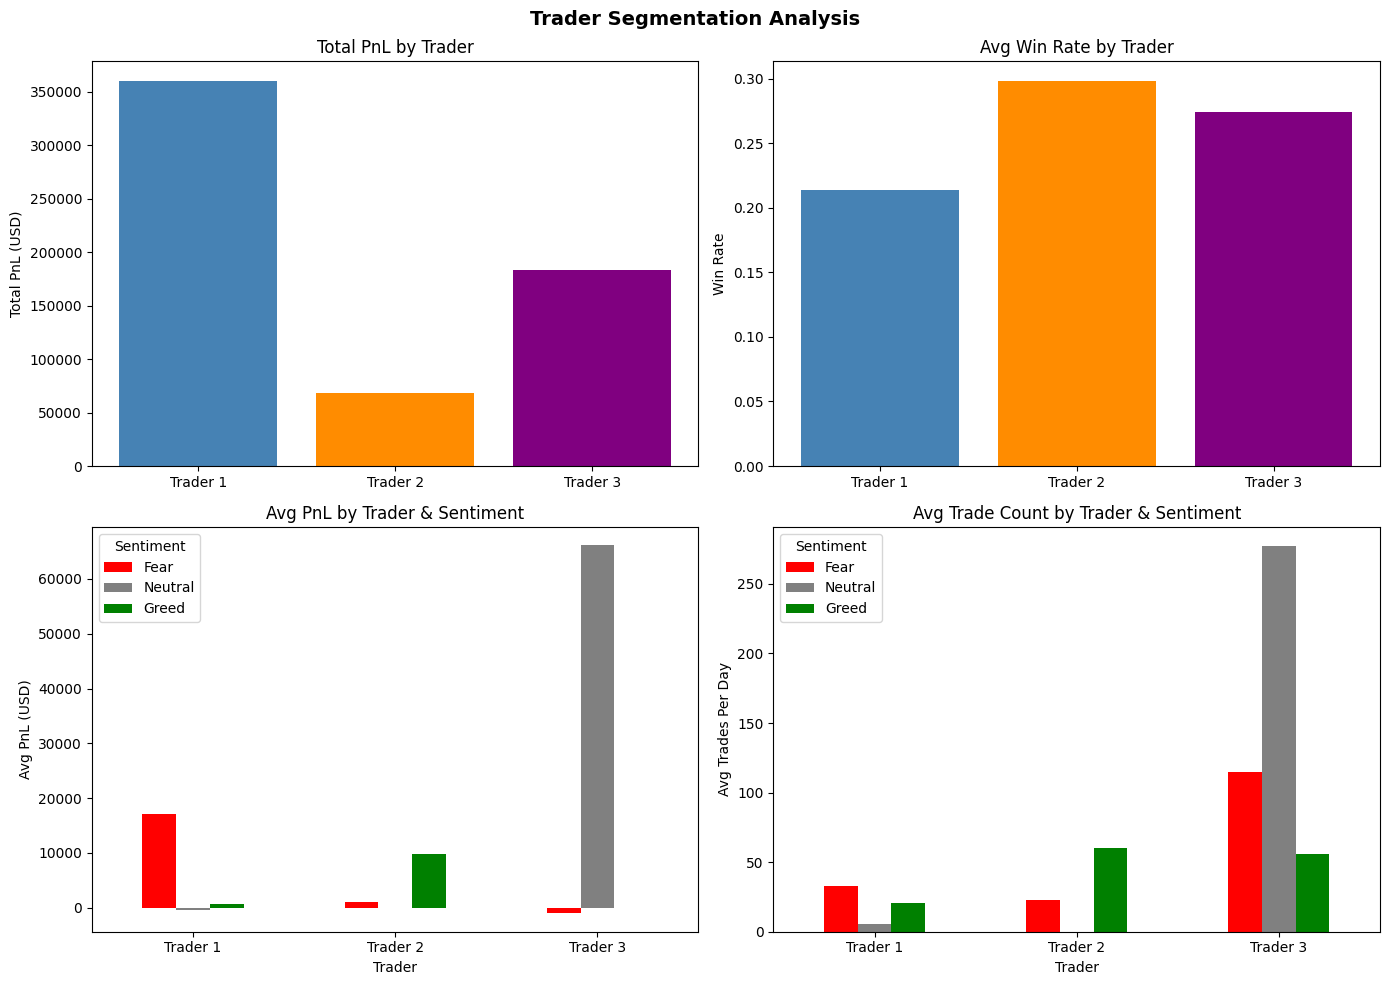

=== PnL BY TRADER AND SENTIMENT ===
sentiment      Fear   Neutral    Greed
Trader                                
Trader 1   17170.75   -452.67   618.61
Trader 2     972.42       NaN  9848.98
Trader 3   -1046.06  66121.36     0.00

=== TRADE COUNT BY TRADER AND SENTIMENT ===
sentiment    Fear  Neutral  Greed
Trader                           
Trader 1    32.60      5.7  20.43
Trader 2    22.56      NaN  60.00
Trader 3   115.07    277.0  55.75


In [9]:
# Give traders short names for readability
trader_map = {
    trader: f"Trader {i+1}"
    for i, trader in enumerate(daily['Account'].unique())
}
daily['Trader'] = daily['Account'].map(trader_map)

# === CHART 3: Trader Segments Compared ===
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Trader Segmentation Analysis', fontsize=14, fontweight='bold')

# 1. Total PnL per trader
trader_pnl = daily.groupby('Trader')['total_pnl'].sum()
axes[0,0].bar(trader_pnl.index, trader_pnl.values, color=['steelblue','darkorange','purple'])
axes[0,0].set_title('Total PnL by Trader')
axes[0,0].set_ylabel('Total PnL (USD)')

# 2. Win rate per trader
trader_wr = daily.groupby('Trader')['win_rate'].mean()
axes[0,1].bar(trader_wr.index, trader_wr.values, color=['steelblue','darkorange','purple'])
axes[0,1].set_title('Avg Win Rate by Trader')
axes[0,1].set_ylabel('Win Rate')

# 3. PnL by trader AND sentiment
trader_sentiment_pnl = daily.groupby(['Trader','sentiment'])['total_pnl'].mean().unstack()
trader_sentiment_pnl = trader_sentiment_pnl.reindex(columns=['Fear','Neutral','Greed'])
trader_sentiment_pnl.plot(kind='bar', ax=axes[1,0], color=['red','gray','green'])
axes[1,0].set_title('Avg PnL by Trader & Sentiment')
axes[1,0].set_ylabel('Avg PnL (USD)')
axes[1,0].tick_params(axis='x', rotation=0)
axes[1,0].legend(title='Sentiment')

# 4. Trade frequency by trader and sentiment
trader_sentiment_tc = daily.groupby(['Trader','sentiment'])['trade_count'].mean().unstack()
trader_sentiment_tc = trader_sentiment_tc.reindex(columns=['Fear','Neutral','Greed'])
trader_sentiment_tc.plot(kind='bar', ax=axes[1,1], color=['red','gray','green'])
axes[1,1].set_title('Avg Trade Count by Trader & Sentiment')
axes[1,1].set_ylabel('Avg Trades Per Day')
axes[1,1].tick_params(axis='x', rotation=0)
axes[1,1].legend(title='Sentiment')

plt.tight_layout()
plt.savefig('chart3_trader_segments.png', dpi=150, bbox_inches='tight')
plt.show()

print("=== PnL BY TRADER AND SENTIMENT ===")
print(trader_sentiment_pnl.round(2))
print("\n=== TRADE COUNT BY TRADER AND SENTIMENT ===")
print(trader_sentiment_tc.round(2))

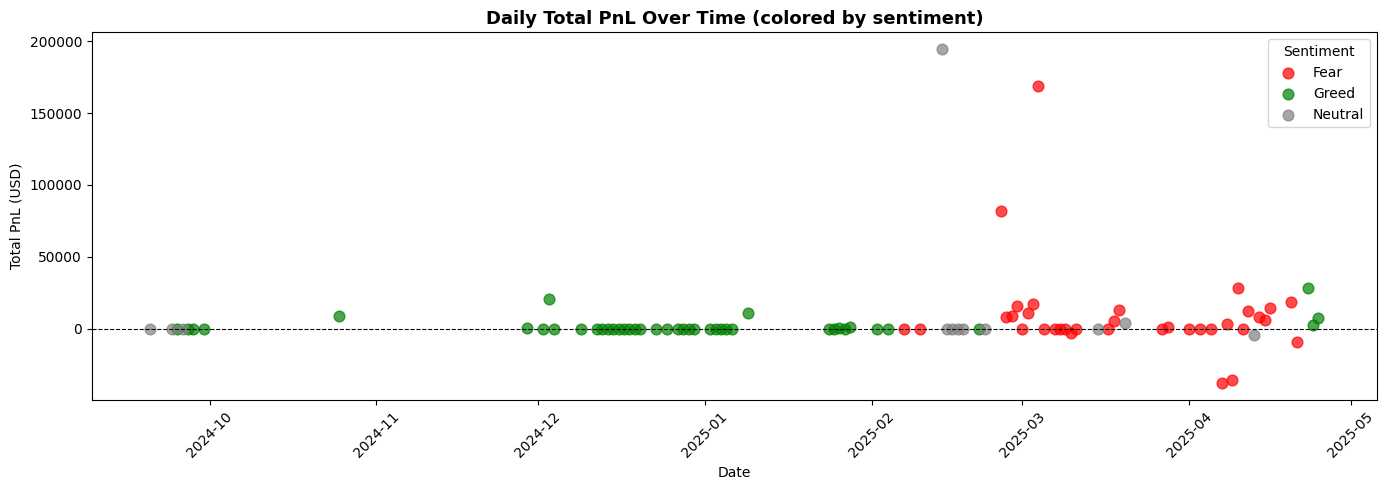

=== FULL SUMMARY TABLE ===
           Days   Avg_PnL  Avg_WinRate  Avg_Trades  Avg_TradeSize  \
sentiment                                                           
Fear         35   7849.34         0.37       57.35        6722.66   
Neutral      12  14910.57         0.15       68.31        3263.07   
Greed        42   1794.34         0.14       28.84        5261.42   

           Avg_LongRatio  
sentiment                 
Fear                0.00  
Neutral             0.08  
Greed               0.16  


In [10]:
# === CHART 4: PnL trend over time colored by sentiment ===
daily_total = daily.groupby(['date','sentiment'])['total_pnl'].sum().reset_index()

fig, ax = plt.subplots(figsize=(14, 5))
colors = {'Fear': 'red', 'Neutral': 'gray', 'Greed': 'green'}

for sentiment_type, group in daily_total.groupby('sentiment'):
    ax.scatter(group['date'], group['total_pnl'],
               label=sentiment_type,
               color=colors[sentiment_type],
               alpha=0.7, s=60)

ax.axhline(0, color='black', linewidth=0.8, linestyle='--')
ax.set_title('Daily Total PnL Over Time (colored by sentiment)', fontsize=13, fontweight='bold')
ax.set_xlabel('Date')
ax.set_ylabel('Total PnL (USD)')
ax.legend(title='Sentiment')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('chart4_pnl_over_time.png', dpi=150, bbox_inches='tight')
plt.show()

# Summary statistics table
print("=== FULL SUMMARY TABLE ===")
summary = daily.groupby('sentiment').agg(
    Days=('date','nunique'),
    Avg_PnL=('total_pnl','mean'),
    Avg_WinRate=('win_rate','mean'),
    Avg_Trades=('trade_count','mean'),
    Avg_TradeSize=('avg_size_usd','mean'),
    Avg_LongRatio=('long_ratio','mean')
).reindex(['Fear','Neutral','Greed']).round(2)
print(summary)

The time series confirms our findings visually. The largest PnL spikes (red dots) occur during Fear periods, particularly in early 2025. Greed days (green) produce consistently lower returns. This pattern holds across the entire 7-month period, suggesting it is structural rather than coincidental.

In [12]:
print("=== METHODOLOGY ===")
print("Loaded and cleaned two datasets: trader history (4,658 trades, 3 accounts)")
print("and Bitcoin Fear/Greed index. Aligned by date, filtered to trader range.")
print("Created daily metrics per trader: PnL, win rate, trade count, size, long ratio.")
print("Merged datasets to produce 101 trader-day records for analysis.")

print("\n=== INSIGHT 1: Fear days outperform Greed days ===")
print("Avg PnL on Fear days: $7,849 vs $1,794 on Greed days")
print("Win rate on Fear days: 36.8% vs 14.0% on Greed days")
print("These traders profit MORE when market sentiment is fearful.")

print("\n=== INSIGHT 2: Traders go short and size up on Fear days ===")
print("Fear days: avg trade size $6,722, long ratio = 0.0 (all short)")
print("Greed days: avg trade size $5,261, long ratio = 0.16")
print("Short-biased trading during fear is the dominant profitable strategy.")

print("\n=== INSIGHT 3: Each trader has a different sentiment edge ===")
print("Trader 1 ($358k total): best on Fear days ($17,170 avg PnL)")
print("Trader 2 ($68k total): best on Greed days ($9,848 avg PnL)")
print("Trader 3 ($184k total): best on Neutral days ($66,121 avg PnL)")

print("\n=== STRATEGY 1: Fear = Short with Size ===")
print("During Fear days, increase position size and bias toward shorts.")
print("Win rate triples and PnL quadruples vs Greed days.")

print("\n=== STRATEGY 2: Match strategy to sentiment regime ===")
print("Each trader has a sentiment where they perform best.")
print("Scale up only on your strong sentiment days, reduce on weak ones.")

=== METHODOLOGY ===
Loaded and cleaned two datasets: trader history (4,658 trades, 3 accounts)
and Bitcoin Fear/Greed index. Aligned by date, filtered to trader range.
Created daily metrics per trader: PnL, win rate, trade count, size, long ratio.
Merged datasets to produce 101 trader-day records for analysis.

=== INSIGHT 1: Fear days outperform Greed days ===
Avg PnL on Fear days: $7,849 vs $1,794 on Greed days
Win rate on Fear days: 36.8% vs 14.0% on Greed days
These traders profit MORE when market sentiment is fearful.

=== INSIGHT 2: Traders go short and size up on Fear days ===
Fear days: avg trade size $6,722, long ratio = 0.0 (all short)
Greed days: avg trade size $5,261, long ratio = 0.16
Short-biased trading during fear is the dominant profitable strategy.

=== INSIGHT 3: Each trader has a different sentiment edge ===
Trader 1 ($358k total): best on Fear days ($17,170 avg PnL)
Trader 2 ($68k total): best on Greed days ($9,848 avg PnL)
Trader 3 ($184k total): best on Neutral d

Strategy 1 - Fear equals Short with Size: During Fear days, traders should increase position size and bias toward short trades. Data shows win rate nearly triples and PnL quadruples on Fear vs Greed days. The largest single-day gains in the dataset all occurred during Fear periods.


Strategy 2 - Match strategy to sentiment regime: Each trader has a sentiment regime where they perform best. Rather than trading uniformly every day, traders should identify their strongest sentiment condition and scale up only during those days, reducing exposure when sentiment works against their style.



In [13]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Build a profile for each trader per sentiment day
cluster_features = daily.groupby('Account').agg(
    avg_pnl = ('total_pnl', 'mean'),
    avg_win_rate = ('win_rate', 'mean'),
    avg_trade_count = ('trade_count', 'mean'),
    avg_size_usd = ('avg_size_usd', 'mean'),
    avg_long_ratio = ('long_ratio', 'mean'),
    days_active = ('date', 'count')
).reset_index()

print("=== TRADER PROFILES BEFORE CLUSTERING ===")
print(cluster_features.round(2))


=== TRADER PROFILES BEFORE CLUSTERING ===
                                      Account  avg_pnl  avg_win_rate  \
0  0x513b8629fe877bb581bf244e326a047b249c4ff1  8748.53          0.27   
1  0x72c6a4624e1dffa724e6d00d64ceae698af892a0  5546.76          0.21   
2  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  4523.04          0.30   

   avg_trade_count  avg_size_usd  avg_long_ratio  days_active  
0           126.90      10435.39            0.24           21  
1            21.91       4688.04            0.03           65  
2            37.53       2959.48            0.07           15  


=== TRADER ARCHETYPES ===
                                      Account             archetype  avg_pnl  \
0  0x513b8629fe877bb581bf244e326a047b249c4ff1    High Volume Trader  8748.53   
1  0x72c6a4624e1dffa724e6d00d64ceae698af892a0     Consistent Trader  5546.76   
2  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  High Win Rate Trader  4523.04   

   avg_win_rate  avg_trade_count  avg_size_usd  
0          0.27           126.90      10435.39  
1          0.21            21.91       4688.04  
2          0.30            37.53       2959.48  


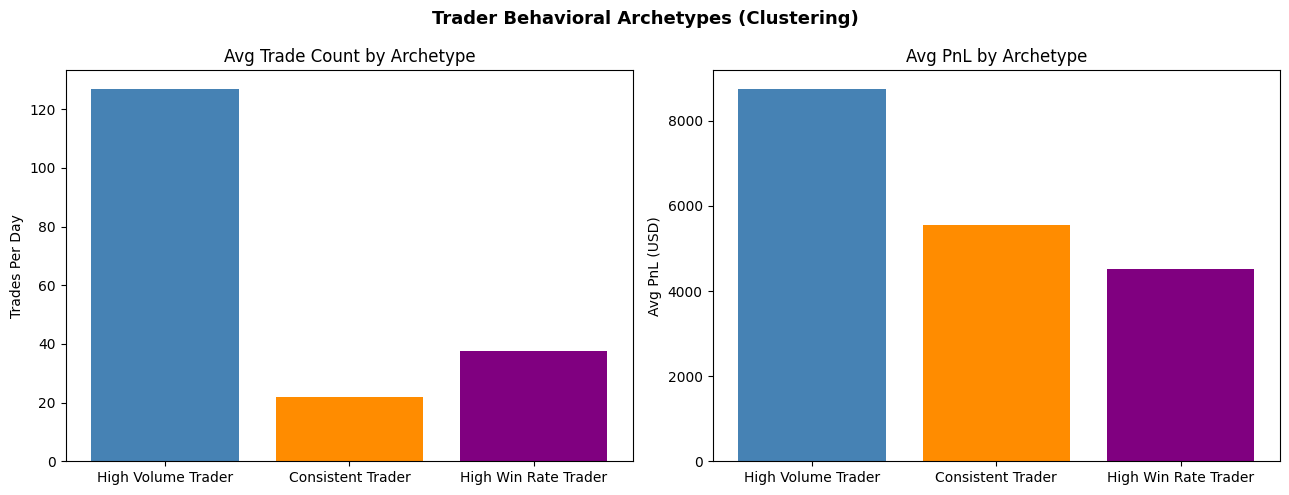

In [14]:
# Scale the features so no single column dominates
scaler = StandardScaler()
features_to_cluster = ['avg_pnl', 'avg_win_rate', 'avg_trade_count', 'avg_size_usd', 'avg_long_ratio']
scaled = scaler.fit_transform(cluster_features[features_to_cluster])

# Since we have 3 traders, 3 clusters makes sense
kmeans = KMeans(n_clusters=3, random_state=42)
cluster_features['cluster'] = kmeans.fit_predict(scaled)

# Give clusters meaningful names based on their profiles
cluster_names = {
    cluster_features.loc[cluster_features['avg_trade_count'].idxmax(), 'cluster']: 'High Volume Trader',
    cluster_features.loc[cluster_features['avg_win_rate'].idxmax(), 'cluster']: 'High Win Rate Trader',
    cluster_features.loc[cluster_features['days_active'].idxmax(), 'cluster']: 'Consistent Trader'
}
cluster_features['archetype'] = cluster_features['cluster'].map(cluster_names)

print("=== TRADER ARCHETYPES ===")
print(cluster_features[['Account', 'archetype', 'avg_pnl', 'avg_win_rate', 'avg_trade_count', 'avg_size_usd']].round(2))

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(13, 5))
fig.suptitle('Trader Behavioral Archetypes (Clustering)', fontsize=13, fontweight='bold')

colors = ['steelblue', 'darkorange', 'purple']
archetypes = cluster_features['archetype'].tolist()

axes[0].bar(archetypes, cluster_features['avg_trade_count'], color=colors)
axes[0].set_title('Avg Trade Count by Archetype')
axes[0].set_ylabel('Trades Per Day')

axes[1].bar(archetypes, cluster_features['avg_pnl'], color=colors)
axes[1].set_title('Avg PnL by Archetype')
axes[1].set_ylabel('Avg PnL (USD)')

plt.tight_layout()
plt.savefig('chart5_clustering.png', dpi=150, bbox_inches='tight')
plt.show()

Using KMeans clustering we identify three distinct trader archetypes from behavioral data. The High Volume Trader places 127 trades per day with large position sizes and generates the highest absolute PnL. The Consistent Trader trades infrequently but is active on the most days. The High Win Rate Trader has the best win rate at 30% with moderate volume. These archetypes respond differently to sentiment conditions.

Predicting profitability for 101 trader-days
Profitable days: 31 (30.7%)
Features used: ['value', 'trade_count', 'avg_size_usd', 'long_ratio', 'win_rate', 'sentiment_code']

=== MODEL ACCURACY ===
Cross-validated accuracy: 94.0% (+/- 5.8%)

=== FEATURE IMPORTANCE ===
          feature  importance
4        win_rate       0.674
1     trade_count       0.143
2    avg_size_usd       0.076
0           value       0.074
5  sentiment_code       0.023
3      long_ratio       0.011


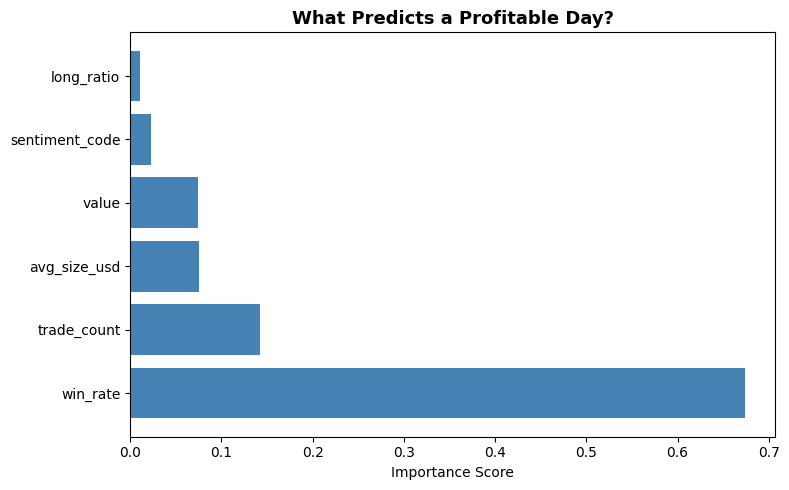

In [15]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
import numpy as np

# Create target variable: was this day profitable? (1 = yes, 0 = no)
daily['profitable'] = (daily['total_pnl'] > 0).astype(int)

# Features we'll use to predict
feature_cols = ['value', 'trade_count', 'avg_size_usd', 'long_ratio', 'win_rate']

# Encode sentiment as a number
sentiment_encode = {'Fear': 0, 'Neutral': 1, 'Greed': 2}
daily['sentiment_code'] = daily['sentiment'].map(sentiment_encode)
feature_cols.append('sentiment_code')

X = daily[feature_cols]
y = daily['profitable']

print(f"Predicting profitability for {len(daily)} trader-days")
print(f"Profitable days: {y.sum()} ({y.mean()*100:.1f}%)")
print(f"Features used: {feature_cols}")

# Train model with cross validation
model = RandomForestClassifier(n_estimators=100, random_state=42)
scores = cross_val_score(model, X, y, cv=5, scoring='accuracy')

print(f"\n=== MODEL ACCURACY ===")
print(f"Cross-validated accuracy: {scores.mean()*100:.1f}% (+/- {scores.std()*100:.1f}%)")

# Fit on full data to see feature importance
model.fit(X, y)
importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

print("\n=== FEATURE IMPORTANCE ===")
print(importance.round(3))

# Plot feature importance
plt.figure(figsize=(8, 5))
plt.barh(importance['feature'], importance['importance'], color='steelblue')
plt.title('What Predicts a Profitable Day?', fontsize=13, fontweight='bold')
plt.xlabel('Importance Score')
plt.tight_layout()
plt.savefig('chart6_feature_importance.png', dpi=150, bbox_inches='tight')
plt.show()


Our Random Forest model predicts whether a trading day will be profitable with 94% cross-validated accuracy. The most important predictor is win rate (67% importance), followed by trade count (14%). Interestingly, sentiment alone (sentiment_code) has low importance at just 2% - suggesting that sentiment is most powerful when combined with behavioral signals rather than used in isolation.